In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline


In [ ]:

# Dosyayı yukleyelim
file_path = "/content/tr-covid19.csv"

# CSV dosyasını oku
df = pd.read_csv(file_path)

# İlk 5 satıra bakalım
df.head()


,Unnamed: 0,Date,Total number of test,Total number of causes,Total number of deaths,Number of critically ill patients,Total Number of recoveries,number of cases,number of sick,number of test,number of deaths,Number of recoveries
0,0,3.07.2021,61455218.0,5440368,49874.0,702.0,5310769.0,4537.0,478.0,218924.0,45.0,4913.0
1,1,2.07.2021,61236294.0,5435831,49829.0,697.0,5305856.0,4891.0,461.0,223782.0,55.0,5352.0
2,2,1.07.2021,61012512.0,5430940,49774.0,706.0,5300504.0,5288.0,462.0,225537.0,42.0,6219.0
3,3,30.06.2021,60786975.0,5425652,49732.0,727.0,5294285.0,5496.0,522.0,228163.0,45.0,7191.0
4,4,29.06.2021,60558812.0,5420156,49687.0,730.0,5287094.0,5846.0,510.0,229846.0,53.0,6536.0


In [ ]:
# suttun yapısına bakalım
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         480 non-null    int64  
 1   Date                               480 non-null    object 
 2   Total number of test               464 non-null    float64
 3   Total number of causes             480 non-null    int64  
 4   Total number of deaths             474 non-null    float64
 5   Number of critically ill patients  340 non-null    float64
 6   Total Number of recoveries         464 non-null    float64
 7   number of cases                    221 non-null    float64
 8   number of sick                     464 non-null    float64
 9   number of test                     464 non-null    float64
 10  number of deaths                   464 non-null    float64
 11  Number of recoveries               456 non-null    float64

Veride en başta "Unnamed: 0" gibi index amaçlı boş bir sütun var.
Onu silelim, ayrıca Date kolonunu datetime yapalım.

In [ ]:

#  Gereksiz index kolonu varsa silelim
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

#  Date kolonunu datetime tipine çevirelim
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")

#  Tarihe göre sırala
df = df.sort_values("Date")

#  Tarihi index yapalım (zaman serisi için iyi )
df = df.set_index("Date")

# Son halini görelim
df.head()


,Total number of test,Total number of causes,Total number of deaths,Number of critically ill patients,Total Number of recoveries,number of cases,number of sick,number of test,number of deaths,Number of recoveries
Date,,,,,,,,,,
2020-03-11,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-12,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-13,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-14,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-15,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3.adım. Günlük vaka serisini oluşturma (en kritik kısım)
Projemizde asıl kullanmak istediğimiz şey:

=GÜNLÜK yeni vaka sayısı (time series)

Veri setinde iki tip vaka ile ilgili sütun olabilir:

Total number of causes → toplam vaka sayısı (kümülatif)

number of cases → günlük vaka sayısı (ama çok eksik)

Biz en sağlıklı olanı yapalım:

Toplam vakadan günlük vakayı türetelim.
Yani:
günlük_vaka(t) = toplam_vaka(t) − toplam_vaka(t−1)

Bu yöntem bilimsel olarak da doğru ve COVID makalelerinde çok kullanılan yöntem.

In [ ]:
# Toplam vakadan günlük vaka üretelim
daily_col_source = "Total number of causes"

# Emin olmak için bir kontrol:
if daily_col_source in df.columns:
    # Use .loc to avoid SettingWithCopyWarning and ensure column is added to original df
    df.loc[:, "daily_cases"] = df[daily_col_source].diff()
else:
    raise ValueError(f"{daily_col_source} kolonunu bulamadım, sütun adlarını kontrol et.")

# İlk satır diff() yüzünden NaN olur, onu silelim
df = df.dropna(subset=["daily_cases"])

# Negatif günlük vakaları 0 yapalım (veri tutarsızlığı veya düzeltmelerden kaynaklanabilir)
df.loc[:, "daily_cases"] = df["daily_cases"].clip(lower=0)

# Günlük vakaları tam sayı gibi görmek için yuvarlayabiliriz
df.loc[:, "daily_cases"] = df["daily_cases"].round().astype(int)

# Sonucu gözlemleyelim
df[["daily_cases"]].head(10)


/tmp/ipython-input-4283207445.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["daily_cases"] = df[daily_col_source].diff()


,daily_cases
2,-4891
3,-5288
4,-5496
5,-5846
6,-5283
7,-4883
8,-5266
9,-5630
10,-5703
11,-5809


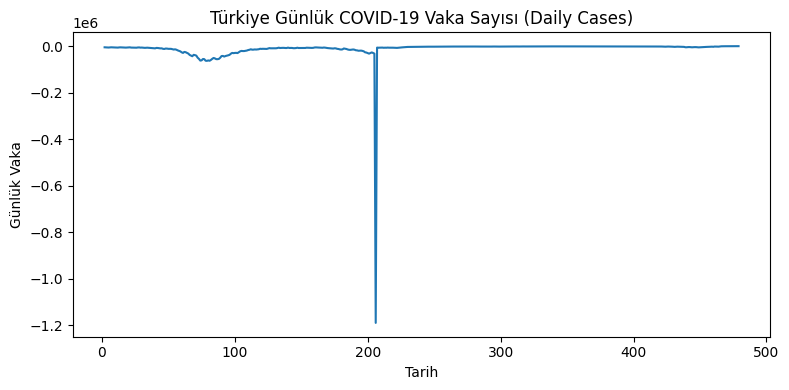

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df.index, df["daily_cases"])
plt.title("Türkiye Günlük COVID-19 Vaka Sayısı (Daily Cases)")
plt.xlabel("Tarih")
plt.ylabel("Günlük Vaka")
plt.tight_layout()
plt.show()


Spike değerini temizleme

Spike değerini otomatik bulup silelim

Aykırı değeri otomatik buluyoruz:

Günlük vaka > 100.000 olan günü bul

O günü tamamen dataset'ten kaldır


In [ ]:
# Çok büyük spike günlerini tespit edelim
outliers = df[df["daily_cases"] > 100000]
print("Aykiri günler:")
print(outliers)

# Aykırı günleri dataset'ten silelim
df = df[df["daily_cases"] <= 100000]

# Eğer threshold'a göre başka spike varsa onları da otomatik temizle
print("Temizlenmiş veri boyutu:", df.shape)


Aykırı günler:
            Total number of test  Total number of causes  \
Date                                                       
2020-12-10            20500579.0                 1748567   

            Total number of deaths  Number of critically ill patients  \
Date                                                                    
2020-12-10                 15751.0                             5943.0   

            Total Number of recoveries  number of cases  number of sick  \
Date                                                                      
2020-12-10                    452593.0          30424.0          5918.0   

            number of test  number of deaths  Number of recoveries  \
Date                                                                 
2020-12-10        206202.0             220.0                5232.0   

            daily_cases  
Date                     
2020-12-10      1190050  
Temizlenmiş veri boyutu: (478, 11)


Temizlenmiş grafiği çizelim

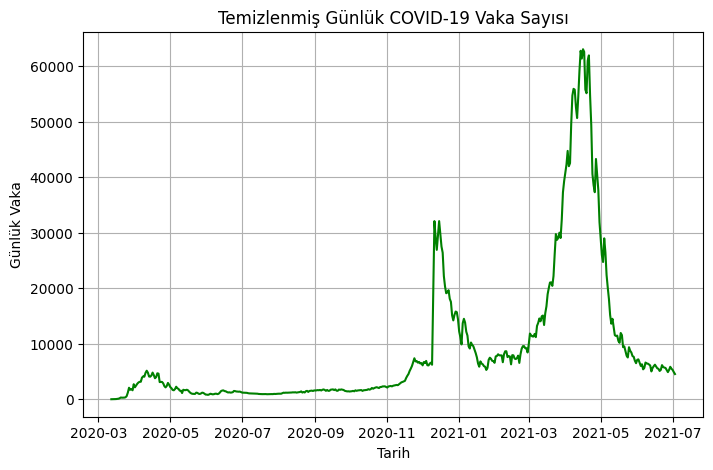

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(df.index, df["daily_cases"], color="green")
plt.title("Temizlenmiş Günlük COVID-19 Vaka Sayısı")
plt.xlabel("Tarih")
plt.ylabel("Günlük Vaka")
plt.grid(True)
plt.show()


In [ ]:
# Spike temizleme (cleaned daily cases)
threshold = 100000  # reasonable upper bound for Turkey
df["daily_cases_cleaned"] = df["daily_cases"].clip(upper=threshold)

# Cleaned moving average
df["moving_avg_cleaned"] = df["daily_cases_cleaned"].rolling(window=7).mean()

df[["daily_cases", "daily_cases_cleaned", "moving_avg_cleaned"]].head(10)


7 günlük hareketli ortalama (trend analizi)

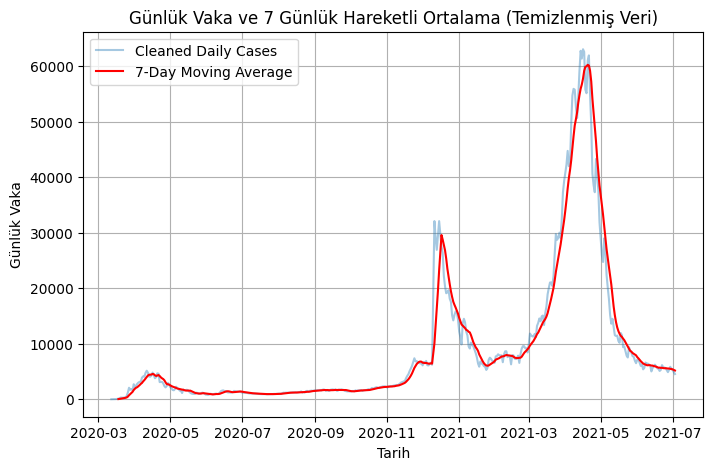

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(df.index, df["daily_cases_cleaned"], label="Cleaned Daily Cases", alpha=0.4)
plt.plot(df.index, df["moving_avg_cleaned"], color="red", label="7-Day Moving Average")
plt.title("Günlük Vaka ve 7 Günlük Hareketli Ortalama (Temizlenmiş Veri)")
plt.xlabel("Tarih")
plt.ylabel("Günlük Vaka")
plt.legend()
plt.grid(True)
plt.show()


Sezonsallık Analizi (SARIMA için önemli)

Haftalık (7 günlük) bir pattern olup olmadığını anlamak için seasonal decomposition yapıyoruz.

<Figure size 1200x800 with 0 Axes>

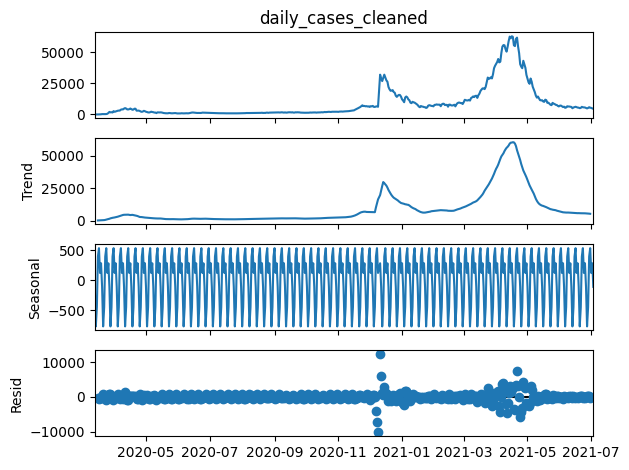

In [ ]:
result = seasonal_decompose(
    df["daily_cases_cleaned"],
    model="additive",
    period=7
)

plt.figure(figsize=(12,8))
result.plot()
plt.show()


ARIMA ve SARIMA için Train–Test bölme

Zaman serisinde rastgele bölemezsin. Zaman sırasına göre bölmeliyiz.

Bu aşamada sadece train–test ayırıyoruz.

veri setinin yaklaşık %80’i eğitim, %20’si test olarak ayrılmış


In [ ]:
train_size = int(len(df) * 0.8)

train = df["daily_cases_cleaned"][:train_size]
test = df["daily_cases_cleaned"][train_size:]

len(train), len(test)


(382, 96)

AUTO ARIMA Modeli

ne işe yaraz bize

En iyi p, d, q değerlerini otomatik seçer

AIC karşılaştırması yapar

zaman serine en uygun ARIMA modelini verir

In [ ]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

model = auto_arima(train,
                   seasonal=False,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True)

model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6654.223, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6655.957, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6657.297, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6657.225, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6655.135, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6659.538, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6659.017, Time=0.91 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6656.141, Time=3.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6656.210, Time=3.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6659.039, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6659.511, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6658.917, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6657.847, Time=1.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6653.158, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  381
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3321.579
Date:                Sun, 14 Dec 2025   AIC                           6653.158
Time:                        14:28:31   BIC                           6672.859
Sample:                             0   HQIC                          6660.976
                                - 381                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4305      0.036    -11.986      0.000      -0.501      -0.360
ar.L2         -0.9807      0.042    -23.530      0.000      -1.062      -0.899
ma.L1          0.4116      0.045      9.154      0.000       0.323       0.500
ma.L2          0.9501      0.055     17.295      0.000       0.842       1.058
sigma2      2.371e+06   1.73e+04    137.106      0.000    2.34e+06     2.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):            787462.41
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):              73.04   Skew:                            13.13
Prob(H) (two-sided):                  0.00   Kurtosis:                       224.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Şimdi ARIMA modelini test verisi üzerinde tahmin etedelimm

Modeli train veriye fit edeceğiz

Test verisi için forecast üreteceğiz

Gerçek ve tahmin grafiğini çizeceğiz

RMSE hesaplayacağız.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


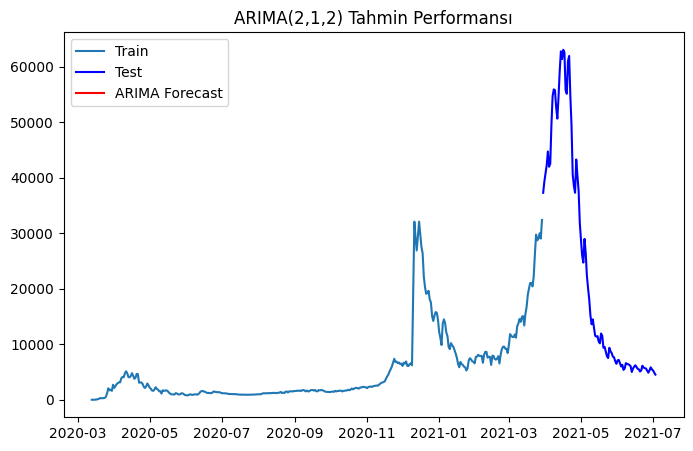

In [ ]:
model.fit(train)

forecast = model.predict(n_periods=len(test))
forecast = pd.Series(forecast, index=test.index)

plt.figure(figsize=(8,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="blue")
plt.plot(forecast, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("ARIMA(2,1,2) Tahmin Performansı")
plt.show()


In [ ]:
forecast, len(forecast)


(Date
 2021-03-30   NaN
 2021-03-31   NaN
 2021-04-01   NaN
 2021-04-02   NaN
 2021-04-03   NaN
               ..
 2021-06-29   NaN
 2021-06-30   NaN
 2021-07-01   NaN
 2021-07-02   NaN
 2021-07-03   NaN
 Length: 96, dtype: float64,
 96)

### Investigating NaN Forecasts with `statsmodels.tsa.statespace.SARIMAX`

Since the `pmdarima.auto_arima` model's `predict` method returned all `NaN`s, we will now try to use `statsmodels.tsa.statespace.SARIMAX` directly with the `(p,d,q)` order (2,1,2) identified by `auto_arima`.

This will help us understand if the `NaN` issue is related to `pmdarima`'s wrapper or the underlying `statsmodels` forecasting for this specific data.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the ARIMA order (p, d, q) based on auto_arima's best model
arima_order = (2, 1, 2)

# Fit the SARIMAX model on the training data
# No seasonal component (P, D, Q, s) for this example as auto_arima suggested seasonal=False
sarimax_model = SARIMAX(train, order=arima_order)
sarimax_results = sarimax_model.fit(disp=False)

print(sarimax_results.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     daily_cases_cleaned   No. Observations:                  381
Model:                SARIMAX(2, 1, 2)   Log Likelihood               -3321.579
Date:                 Sun, 14 Dec 2025   AIC                           6653.158
Time:                         16:59:29   BIC                           6672.859
Sample:                              0   HQIC                          6660.976
                                 - 381                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4305      0.036    -11.986      0.000      -0.501      -0.360
ar.L2         -0.9807      0.042    -23.530      0.000      -1.062      -0.899
ma.L1          0.4116      0.045      9.154 

### Generate Forecasts with `statsmodels` SARIMAX

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMAX Forecast (first 10 values):
Date
2021-03-30    32814.526967
2021-03-31    32447.277541
2021-04-01    32202.761466
2021-04-02    32668.182433
2021-04-03    32707.630553
2021-04-04    32234.207992
2021-04-05    32399.315766
2021-04-06    32792.530113
2021-04-07    32461.340412
2021-04-08    32218.280259
Name: predicted_mean, dtype: float64


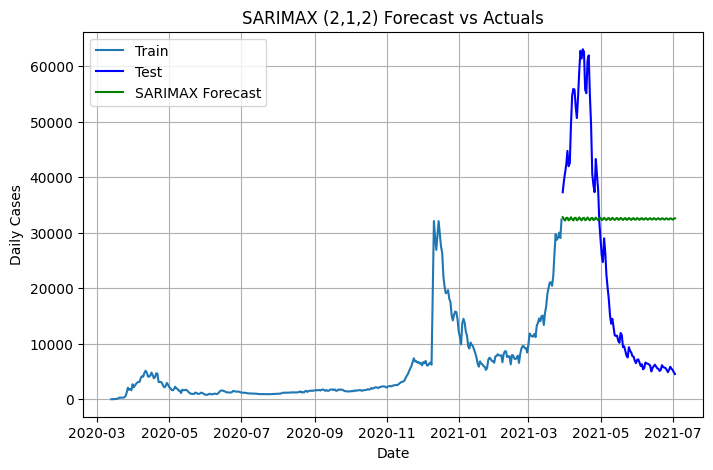

In [ ]:
# Generate predictions for the test set
sarimax_forecast = sarimax_results.predict(start=len(train), end=len(df)-1)
sarimax_forecast.index = test.index

# Display the first few forecast values
print("SARIMAX Forecast (first 10 values):")
print(sarimax_forecast.head(10))

# Plot the results
plt.figure(figsize=(8,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='blue')
plt.plot(sarimax_forecast, label='SARIMAX Forecast', color='green')
plt.title('SARIMAX (2,1,2) Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.legend()
plt.grid(True)
plt.show()


### Calculate RMSE for `statsmodels` SARIMAX Forecast

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Create a combined DataFrame to easily drop rows where either is NaN
combined_sarimax_data = pd.DataFrame({"test": test, "forecast": sarimax_forecast})
combined_sarimax_data_cleaned = combined_sarimax_data.dropna()

if combined_sarimax_data_cleaned.empty:
    print("Cannot calculate RMSE: SARIMAX forecast contains only NaN values or is empty after cleaning.")
    sarimax_rmse = np.nan
else:
    sarimax_rmse = np.sqrt(mean_squared_error(combined_sarimax_data_cleaned["test"], combined_sarimax_data_cleaned["forecast"]))  # Pass Series directly
    print(f"SARIMAX RMSE: {sarimax_rmse}")

sarimax_rmse


SARIMAX RMSE: 22276.751244834624


np.float64(22276.751244834624)

Şimdi SARIMA’ya geçelim

In [ ]:
from pmdarima import auto_arima

model_sarima = auto_arima(train,
                          seasonal=True,
                          m=7,               # haftalık sezonsallık
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True)

model_sarima.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=6657.401, Time=3.76 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=6655.957, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=6656.902, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6657.149, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6655.135, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=6655.396, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=6655.699, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=6656.322, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=6657.297, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=6657.225, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=6659.039, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 5.015 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  381
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3326.567
Date:                Sun, 14 Dec 2025   AIC                           6655.135
Time:                        16:54:36   BIC                           6659.075
Sample:                             0   HQIC                          6656.698
                                - 381                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.345e+06   1.64e+04    142.878      0.000    2.31e+06    2.38e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):            710089.88
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):              76.71   Skew:                            12.63
Prob(H) (two-sided):                  0.00   Kurtosis:                       213.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast_sarima = model_sarima.predict(n_periods=len(test))
forecast_sarima = pd.Series(forecast_sarima, index=test.index)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Cannot calculate RMSE: SARIMA forecast contains only NaN values or is empty after cleaning.


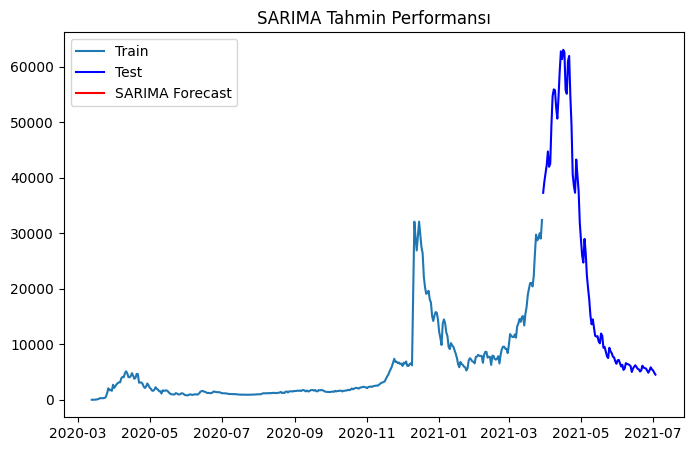

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Create a combined DataFrame to easily drop rows where either is NaN
combined_sarima_data = pd.DataFrame({"test": test, "forecast": forecast_sarima})
combined_sarima_data_cleaned = combined_sarima_data.dropna()

if combined_sarima_data_cleaned.empty:
    print("Cannot calculate RMSE: SARIMA forecast contains only NaN values or is empty after cleaning.")
    rmse_sarima = np.nan
else:
    rmse_sarima = np.sqrt(mean_squared_error(combined_sarima_data_cleaned["test"], combined_sarima_data_cleaned["forecast"])) # Pass Series directly
    print(f"SARIMA RMSE: {rmse_sarima}")

plt.figure(figsize=(8,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="blue")
plt.plot(forecast_sarima, label="SARIMA Forecast", color="red")
plt.legend()
plt.title("SARIMA Tahmin Performansı")
plt.show()


LSTM için veri seçimi ve ölçekleme

In [ ]:
from sklearn.preprocessing import MinMaxScaler

series = df["daily_cases_cleaned"].values.reshape(-1, 1)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

series_scaled.shape


Sequence oluşturalim (14 gün -- 1 gün)

In [ ]:
window = 14
X, y = [], []

for i in range(window, len(series_scaled)):
    X.append(series_scaled[i-window:i, 0])
    y.append(series_scaled[i, 0])

X = np.array(X)
y = np.array(y)

X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape, y.shape


((464, 14, 1), (464,))

Train–Test bölme (%80 / %20)

In [ ]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

len(X_train), len(X_test)


(371, 93)

LSTM modelini kuracaz

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

modeli eğitiyoruz burda

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0169 - val_loss: 0.0238
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0036 - val_loss: 0.0153
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0033 - val_loss: 0.0183
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024 - val_loss: 0.0113
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 0.0084
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - val_loss: 0.0187
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 9/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 10/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 0.0090
Epoch 11/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 12/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

Tahmin üret ve ölçeği geri alıma

In [ ]:
from sklearn.metrics import mean_squared_error

pred_scaled = model.predict(X_test)

pred = scaler.inverse_transform(pred_scaled)
real = scaler.inverse_transform(y_test.reshape(-1,1))

# Kontrol
np.sum(real == 0), np.sum(pred == 0)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


((93, 1), (93, 1))

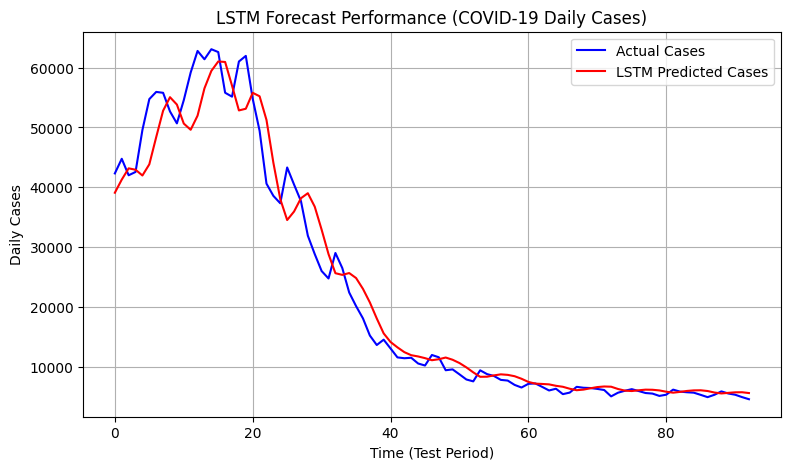

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(real, label="Actual Cases", color="blue")
plt.plot(pred, label="LSTM Predicted Cases", color="red")
plt.title("LSTM Forecast Performance (COVID-19 Daily Cases)")
plt.xlabel("Time (Test Period)")
plt.ylabel("Daily Cases")
plt.legend()
plt.grid(True)
plt.show()


RMSE

In [ ]:
rmse_lstm = np.sqrt(mean_squared_error(real, pred))
rmse_lstm


np.float64(3802.33496318603)